# Beta Regression in PyTorch

Beta regression uses a likelihood based on the Beta distribution, which is ideal for modeling variables constrained to the (0,1) interval like proportions, rates, and probabilities.

The model that we'll fit is based on Ferrari and Cribari-Neto (2004):

\begin{align*}
y_{i} &\sim \textrm{Beta}(p_{i}, q_{i}) ~~~ \textrm{for}~ i=1, ..., N, \\
p_{i} &=\mu_{i}\phi, \\
q_{i} &=(1-\mu_{i})\phi, \\
\textrm{Logit}(\mu_{i}) &= \boldsymbol{x}_{i}^{\top} \boldsymbol{\beta}, 
\end{align*}

where 

* $y_{i} \in (0, 1)$ is the response of the $i\textrm{th}$ observation.
* $\boldsymbol{x}_{i}$ is the vector of covariate values for the $i\textrm{th}$ observation.
* $\boldsymbol{\beta}$ is the vector of effects for the fixed covariates.

The probability density function of the Beta distribution is:

\begin{align*}
f(y_{i}; p_{i}, q_{i}) &= \frac{\Gamma(p_{i}+q_{i})}{\Gamma(p_{i})\Gamma(q_{i})} y_{i}^{p_{i}-1}(1-y_{i})^{q_{i}-1} \\
&= \frac{\Gamma(\phi)}{\Gamma(\mu_{i}\phi)\Gamma((1-\mu_{i})\phi)} y_{i}^{\mu_{i}\phi-1}(1-y_{i})^{(1-\mu_{i})\phi-1}
\end{align*}

Thus, the likelihood is 

\begin{align*}
L(p_{i}, q_{i}; y_{i}) &= \prod_{i=1}^{N}\frac{\Gamma(\phi)}{\Gamma(\mu_{i}\phi)\Gamma((1-\mu_{i})\phi)} y_{i}^{\mu_{i}\phi-1}(1-y_{i})^{(1-\mu_{i})\phi-1} \\
&= \prod_{i=1}^{N}\Gamma(\phi)\Gamma(\mu_{i}\phi)^{-1}\Gamma((1-\mu_{i})\phi)^{-1} y_{i}^{\mu_{i}\phi-1}(1-y_{i})^{(1-\mu_{i})\phi-1}
\end{align*}

The log-likelihood is 

\begin{align*}
\textrm{log}(L(p_{i}, q_{i}; y_{i})) &= \sum_{i=1}^{N}\textrm{log} \bigg[ \Gamma(\phi)\Gamma(\mu_{i}\phi)^{-1}\Gamma((1-\mu_{i})\phi)^{-1} y_{i}^{\mu_{i}\phi-1}(1-y_{i})^{(1-\mu_{i})\phi-1} \bigg] \\
&= \sum_{i=1}^{N} \big[ \textrm{log}(\Gamma(\phi)) - \textrm{log}(\Gamma(\mu_{i}\phi)) - \textrm{log}(\Gamma((1-\mu_{i})\phi)) \\
 &+ (\mu_{i}\phi-1)\textrm{log}(y_{i}) + ((1-\mu_{i})\phi-1) \textrm{log}(1-y_{i}) \big]
\end{align*}

The negative log-likelihood is 

\begin{align*}
-\textrm{log}(L(p_{i}, q_{i}; y_{i})) &= -\sum_{i=1}^{N} \big[ \textrm{log}(\Gamma(\phi)) - \textrm{log}(\Gamma(\mu_{i}\phi)) - \textrm{log}(\Gamma((1-\mu_{i})\phi)) \\
&+ (\mu_{i}\phi-1)\textrm{log}(y_{i}) + ((1-\mu_{i})\phi-1) \textrm{log}(1-y_{i}) \big]
\end{align*}

## Import libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from library.BetaRegression import BetaRegression

## Step 1: Generate synthetic data for the Beta regression

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# We need responses y in (0,1). We use a logistic function to produce μ and then sample from a Beta distribution.
n = 10000  # sample size
p = 3      # number of predictors (excluding intercept)

if p == 1:
    X = torch.linspace(0, 1, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    X = torch.rand(n, p)

# True parameters for Beta Regression
true_beta = torch.randn(p+1, 1) + 1   # parameters for the mean (including intercept)
true_phi = 10.0                # precision parameter

# Create design matrix with intercept and compute true mean: μ = sigmoid(Xβ)
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)
logits = X_with_intercept @ true_beta
true_mu = torch.sigmoid(logits)

# Using the Beta distribution parameters:
# p = μ * φ and q = (1-μ) * φ.
p_true = true_mu * true_phi
q_true_param = (1 - true_mu) * true_phi

# Sample y from the Beta distribution
dist = torch.distributions.Beta(p_true.squeeze(), q_true_param.squeeze())
y = dist.sample().unsqueeze(1)  # ensure y has shape (n, 1)

## Step 2: Plot the data

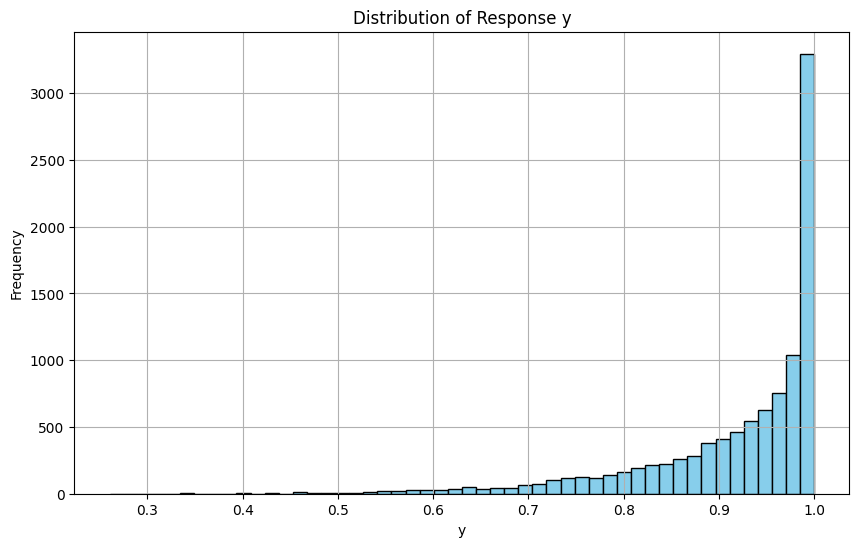

In [3]:
# Plot the response variable "y"
plt.figure(figsize=(10, 6))
plt.hist(y.numpy(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of Response y')
plt.grid(True)
plt.show()

# Step 3: Instantiate model and optimizer

In [4]:
model = BetaRegression(X)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the model

In [5]:
num_epochs = 3000
losses = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop timer
print(f"Training completed in {elapsed_time:.2f} seconds")


Epoch [1000/3000], NLL: -22129.4102
Epoch [2000/3000], NLL: -22215.0312
Epoch [3000/3000], NLL: -22215.0352
Training completed in 4.85 seconds


# Step 5: Extract learned parameters

In [6]:
learned_beta = model.beta.data.flatten()
learned_phi = model.phi().item()

print("Learned parameters:")
print(f"β = {learned_beta.tolist()}")
print(f"φ = {learned_phi:.4f}")
print("True parameters:")
print(f"β = {true_beta.flatten().tolist()}")
print(f"φ = {true_phi:.4f}")


Learned parameters:
β = [0.628423273563385, 1.7479021549224854, 0.2524673342704773, 2.1262717247009277]
φ = 10.2237
True parameters:
β = [0.5898377895355225, 1.8092670440673828, 0.25976496934890747, 2.1415534019470215]
φ = 10.0000


# Step 6: Plot results

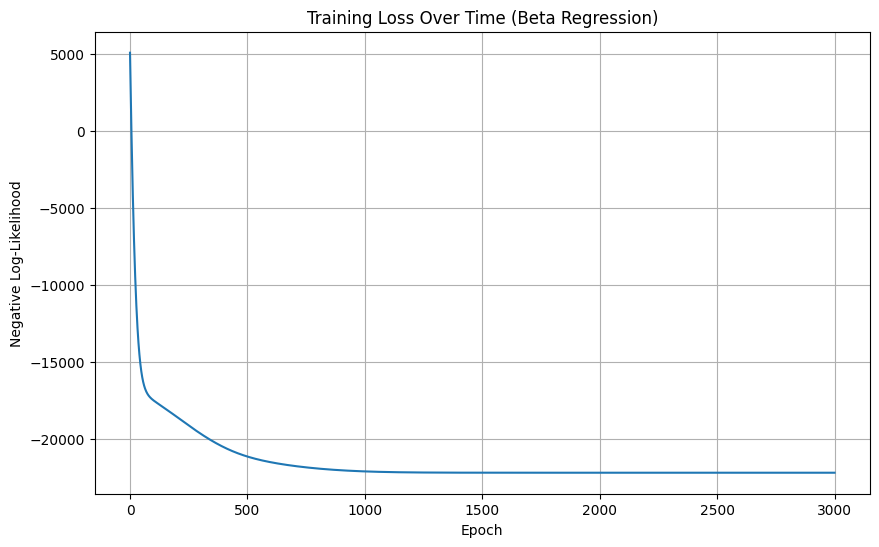

In [7]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time (Beta Regression)')
plt.grid(True)
plt.show()
